In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp

## Setup

In [2]:
from funcs_ex1 import ex1
from funcs_ex2 import ex2

### Load Data

Here I have used the following code in R to convert the .RData file to .csvs:

write.csv(friend, "friend.csv")

write.csv(inschool, "inschool.csv")

In [3]:
friends_raw = pd.read_csv('friend.csv').drop(columns='Unnamed: 0')
schools_raw = pd.read_csv('inschool.csv').drop(columns='Unnamed: 0')

## Exercise 1

### Testing

Since it is hard to understand what is happening with such large graphs I have replicated the small one we saw in the lecture to test out the methods.

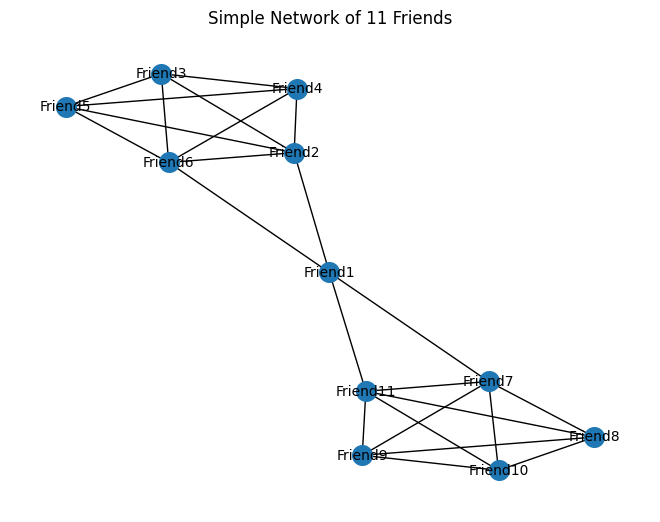

In [4]:
# Create an empty graph
G = nx.Graph()

# Add nodes
friends = ["Friend" + str(i) for i in range(1, 11)]
G.add_nodes_from(friends)

# Add edges between friends
edges = [("Friend1", "Friend2"), ("Friend1", "Friend6"), ("Friend1", "Friend7"), ("Friend1", "Friend11"),
         ("Friend2", "Friend3"), ("Friend2", "Friend4"), ("Friend2", "Friend5"), ("Friend2", "Friend6"),
         ("Friend6", "Friend5"), ("Friend6", "Friend4"), ("Friend6", "Friend3"), ("Friend3", "Friend4"),
         ("Friend7", "Friend8"), ("Friend7", "Friend9"), ("Friend7", "Friend10"), ("Friend7", "Friend11"),
         ("Friend11", "Friend10"), ("Friend11", "Friend9"), ("Friend11", "Friend8"), ("Friend8", "Friend9"),
         ("Friend9", "Friend10"), ("Friend4", "Friend5"), ("Friend5", "Friend3"), ("Friend10", "Friend8")]

G.add_edges_from(edges)

# Draw the network
nx.draw(G, with_labels=True, node_size=200, font_size=10)
plt.title("Simple Network of 11 Friends")
plt.show()


In [5]:
adjacency_matrix = nx.adjacency_matrix(G).astype(np.float64)
adjacency_matrix_sparse = sp.csr_matrix(adjacency_matrix) # much faster using sparse matrix, shoutout to Daniel

eigval1 = sp.linalg.eigsh(adjacency_matrix_sparse, k=1, which='LA', return_eigenvectors=False)
        
max(eigval1) # max here just to return a float isntead of array

4.404046996464427

In [6]:
beta = 0.1
n = adjacency_matrix.shape[0]
I = np.eye(n)  # Identity matrix
# Bonacich centrality
C = np.linalg.inv(I - beta * adjacency_matrix) @ (beta * adjacency_matrix @ np.ones((adjacency_matrix.shape[0], 1)))
            
bonacich_centrality = C.flatten()
bonacich_centrality

array([0.75159236, 0.87898089, 0.71974522, 0.71974522, 0.71974522,
       0.87898089, 0.87898089, 0.71974522, 0.71974522, 0.71974522,
       0.87898089])

In [7]:
node_names = np.array(G.nodes())
# Labels dictionary with bonacich centrality as labels
labels_dict = {}
for i, node in enumerate(node_names):
    labels_dict[node] = round(bonacich_centrality[i],3)

print(labels_dict)

{'Friend1': 0.752, 'Friend2': 0.879, 'Friend3': 0.72, 'Friend4': 0.72, 'Friend5': 0.72, 'Friend6': 0.879, 'Friend7': 0.879, 'Friend8': 0.72, 'Friend9': 0.72, 'Friend10': 0.72, 'Friend11': 0.879}


{0: '0.752', 1: '0.879', 2: '0.72', 3: '0.72', 4: '0.72', 5: '0.879', 6: '0.879', 7: '0.72', 8: '0.72', 9: '0.72', 10: '0.879'}


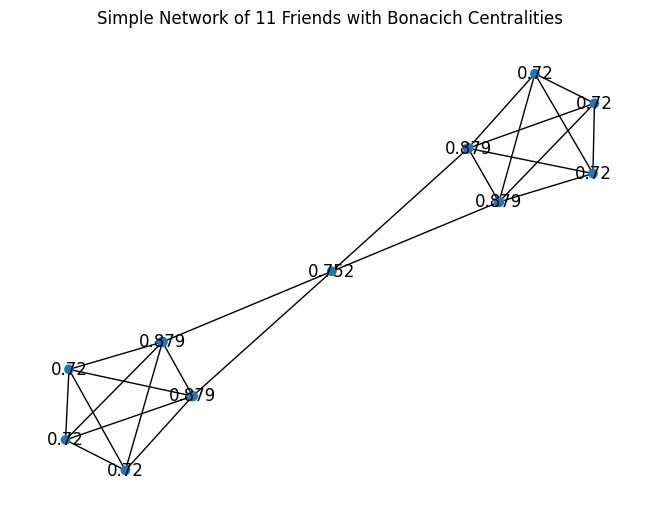

In [8]:
labels = {}
for i in range(len(bonacich_centrality)):
    labels[i] = str(round(bonacich_centrality[i],3))
print(labels)

nx.draw(G, with_labels=True, node_size=bonacich_centrality*50, labels=labels_dict)
plt.title("Simple Network of 11 Friends with Bonacich Centralities")
plt.show()

The method below to get the loops uses that each loop has to go through a neighbor before returning to the starting node. All paths from the starting node to a node that is a neighbor are therefore loops. nx.all_simple_paths also doesnt repeat nodes so only a node with at least two neighbors can have loops which makes sense to me.

In [9]:
list(nx.all_simple_paths(G, source='Friend1', target='Friend2'))

[['Friend1', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend4', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend4', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend5', 'Friend3', 'Friend4', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend3', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend4', 'Friend5', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend4', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend4', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend5', 'Friend2'],
 ['Friend1', 'Friend6', 'Friend3', 'Friend5', 'Friend4', 'Friend2']]

In [10]:
node_to_loops = {}
for source_node in G.nodes():
    paths = []
    for target in G.neighbors(source_node):
         # all paths to neighbors that do not go through the same node twice
        paths_to_neighbors = list(nx.all_simple_paths(G, source=source_node, target=target))
        # only those that are longer than 2 (the starting node is included so when len(l)=2 it is not a loop just an edge to a neighbor)
        paths += [l + [source_node] for l in paths_to_neighbors if len(l) > 2]
    node_to_loops[source_node] = paths
    print(f'Amount of loops starting from {source_node}:  {len(node_to_loops[source_node])}') # take length of the list as the amount of loops

Amount of loops starting from Friend1:  64
Amount of loops starting from Friend2:  92
Amount of loops starting from Friend3:  82
Amount of loops starting from Friend4:  82
Amount of loops starting from Friend5:  82
Amount of loops starting from Friend6:  92
Amount of loops starting from Friend7:  92
Amount of loops starting from Friend8:  82
Amount of loops starting from Friend9:  82
Amount of loops starting from Friend10:  82
Amount of loops starting from Friend11:  92


In [11]:
print(node_to_loops['Friend2'][:10])

[['Friend2', 'Friend3', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend3', 'Friend4', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend3', 'Friend4', 'Friend5', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend3', 'Friend5', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend3', 'Friend5', 'Friend4', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend4', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend4', 'Friend3', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend4', 'Friend3', 'Friend5', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend4', 'Friend5', 'Friend6', 'Friend1', 'Friend2'], ['Friend2', 'Friend4', 'Friend5', 'Friend3', 'Friend6', 'Friend1', 'Friend2']]


Even in this small graph there are many possible loops.

In [12]:
key_players = []
max_intercentrality = 0

for i, node in enumerate(G.nodes()):
    intercentrality = round((bonacich_centrality[i])**2 / len(node_to_loops[source_node]), 5)
    if intercentrality > max_intercentrality:
        key_players = [node]
        max_intercentrality = intercentrality

    elif intercentrality == max_intercentrality:
        key_players.append(node)

    print(f'Node: {node} intercentrality: {intercentrality}')

key_players


Node: Friend1 intercentrality: 0.00614
Node: Friend2 intercentrality: 0.0084
Node: Friend3 intercentrality: 0.00563
Node: Friend4 intercentrality: 0.00563
Node: Friend5 intercentrality: 0.00563
Node: Friend6 intercentrality: 0.0084
Node: Friend7 intercentrality: 0.0084
Node: Friend8 intercentrality: 0.00563
Node: Friend9 intercentrality: 0.00563
Node: Friend10 intercentrality: 0.00563
Node: Friend11 intercentrality: 0.0084


['Friend2', 'Friend6', 'Friend7', 'Friend11']

As we saw in the lecture, the nodes connected to the center node are the ones with the highest bonacich centrality and also the key players (but that doesnt have to be the case always)

### Code

I thought it would be a good idea to use Object Oriented Programming, unfortunately it turned out making everything harder.

The steps are the following:
- **cleaning**: First merging on 'aid', then turning weird ids into missing values and dropping missing 'aid'

- **graphs**: For each school, initialising an empty graph, then adding nodes and edges. Finally just keep the largest connected subgraph. The way I have decided to structure the data is in a dictionary, with the school codes as keys, graphs as items.

- **largest eigenvalue**: Much faster due to using sparse matrix (shoutout to Daniel for the tip!)

- **Bonacich**: According to formula: $$b(g,β)=(I−βG)−1⋅(βG1)$$ Returns another dictionary with the bonacich centrality, which in hindsight could have been part of the main dictionary with the graphs

- **activity**: Adds the activity of each node for each school as an array to the graphs dictionary.

- **aggregate activity**: Sums the activities for each school, adds that value to the graphs dictionary and plots the distribution of normalized aggregate activity

- **median school**: Unfortunately computes the aggregate activities again because the way I saved them in the dictionary would have required another for loop to access them anyway. Then finds the median school.

- **key player**: Here I was not very sure how to interpret $m_{ii}$. I have seen it defined as: "sum of all loops starting from i and ending at i" (Ballester et al 2005) I imagined that even though our graph is undirected, if there is a loop from node 1 to node 2 to node 3 and back to node 1, there also is a loop from node 1 to node 3 to node 2 and back to node 1. Not sure if that is a duplicate. Also, I imagine a loop cannot pass through the same node twice, which means that nodes only connected with one player have no loops and in the formula $ci(g,a)=\frac{bi(g,a)^2}{mii(g,a)}$ we would be dividing by zero? In any case, for a dense graph this method takes forever. So long that I've never seen it finish running. This is the reason why I had to instantiate the class again with a resampled median school (only 20\% of the size of the median school).

In [13]:
ex_one = ex1(friends_raw, schools_raw)

data = ex_one.clean()

In [14]:
school_graphs = ex_one.generate_graphs()

In [15]:
filtered_schools = ex_one.compute_largest_eigenvalues_and_filter(beta=0.1)

In [16]:
bonacich_centralities = ex_one.compute_bonacich_centrality(beta=0.1)

In [17]:
school_graphs = ex_one.compute_activity(alpha=0.01, beta=0.1)

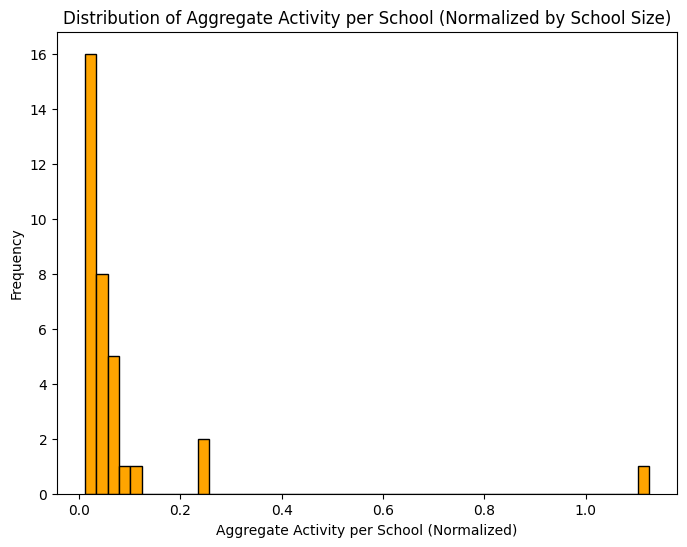

In [18]:
ex_one.aggregate_activity(plot=True)

In [19]:
ex_one.find_median_school()

168

168 is the median school, however I decide to take the next school because it is much smaller in size and makes for better plots and less runtime.

In [20]:
node_names = np.array(school_graphs[28]['graph'].nodes())

labels_dict = {}
for i, node in enumerate(node_names):
    labels_dict[node] = round(bonacich_centralities[28][i],3)

print(labels_dict)

{90575942.0: 2.863, 98575944.0: 5.089, 90575944.0: 3.725, 96575946.0: 4.265, 97575245.0: 4.072, 99575948.0: 5.352, 90575244.0: 3.067, 99575944.0: 2.399, 96575942.0: 2.028, 97575240.0: 4.584, 96575246.0: 1.062, 98575946.0: 2.331, 97575242.0: 16.603, 94575247.0: 2.443, 99575941.0: 1.962, 93575240.0: 6.964, 91575244.0: 8.811, 90575940.0: 5.989, 97575948.0: 10.841, 98575945.0: 13.489, 94575244.0: 7.821, 91575942.0: 10.384, 96575947.0: 10.205, 91575246.0: 4.781, 94575940.0: 3.83, 99575245.0: 1.066, 98575948.0: 4.751, 93575248.0: 6.369, 97575943.0: 1.211, 94575943.0: 1.693, 95575945.0: 2.507, 96575949.0: 2.656, 90575246.0: 1.811, 92575244.0: 1.429, 95575248.0: 1.252, 90575948.0: 8.548, 92575243.0: 3.517, 96575948.0: 3.602, 90575949.0: 3.09, 96575945.0: 4.88, 90575946.0: 8.54, 92575946.0: 3.018, 91575948.0: 3.943, 99575949.0: 3.836, 91575249.0: 8.022, 97575941.0: 4.373, 90575947.0: 1.387, 92575247.0: 6.28, 94575243.0: 5.901, 96575941.0: 4.472, 95575243.0: 8.46, 92575941.0: 6.308, 95575949.0: 

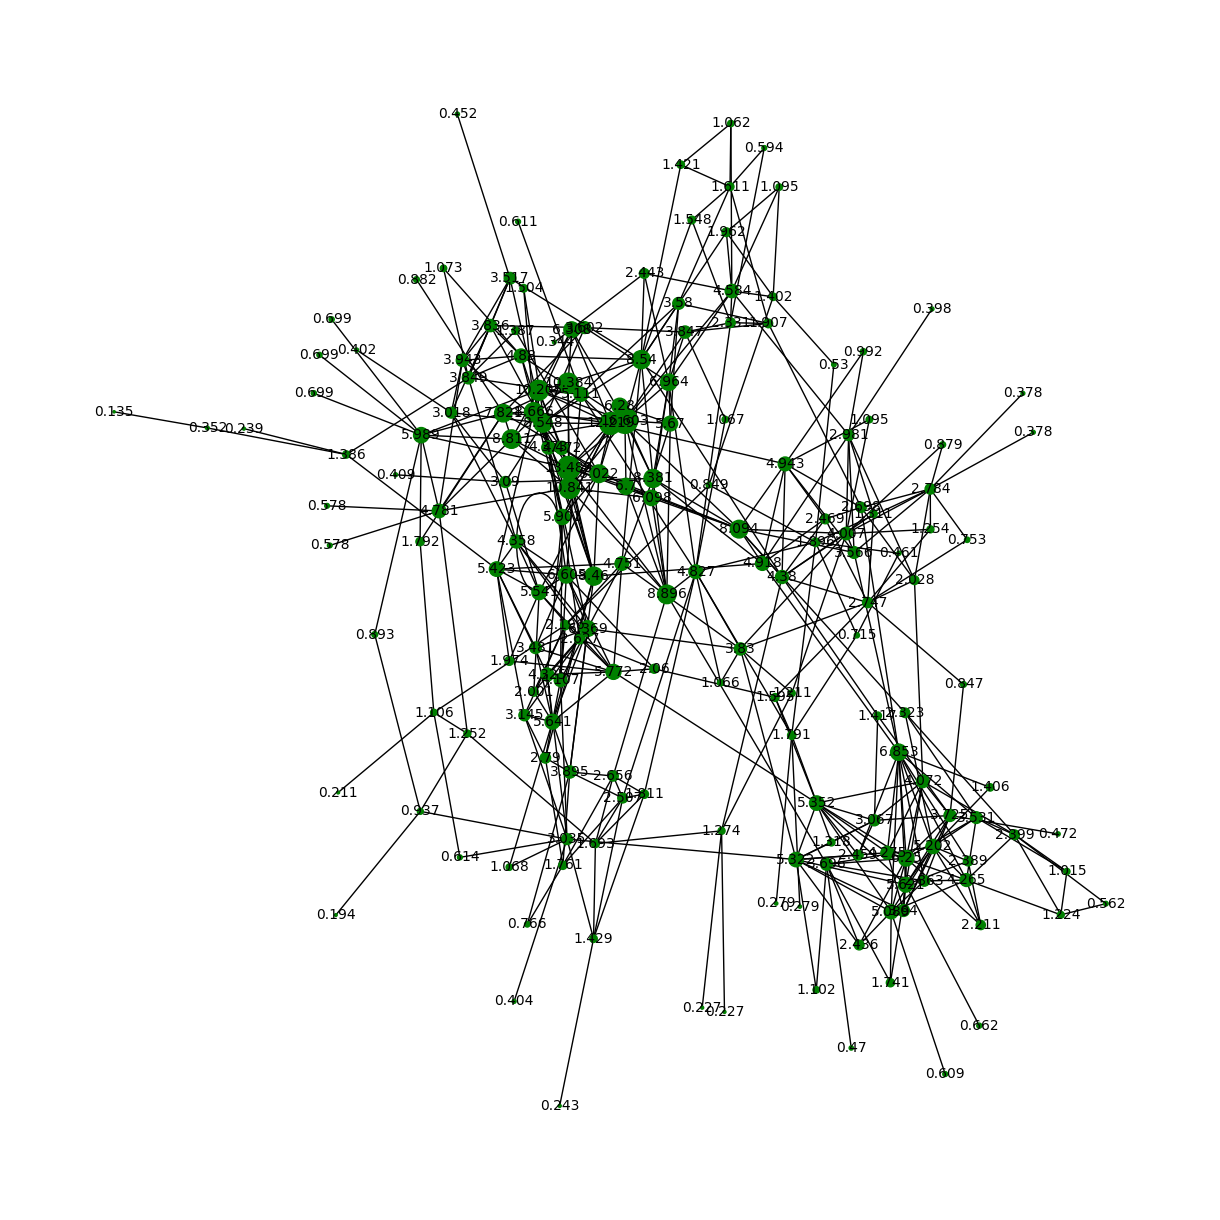

In [21]:
plt.figure(figsize=(12, 12))
nx.draw(school_graphs[28]['graph'], 
        with_labels=True, 
        node_size=bonacich_centralities[28]*20, 
        labels=labels_dict,
        node_color='Green', 
        font_size=10)
plt.show()

In [22]:
schools_raw_28 = schools_raw[schools_raw['sschlcde'] == 28].sample(frac=0.2, random_state=8) # just a fraction because computationally costly

In [23]:
ex_one_f = ex1(friends_raw, schools_raw_28) # new class with just one the fraction of one school

# same steps as before
data = ex_one_f.clean()
school_graph = ex_one_f.generate_graphs()
filtered_schools = ex_one_f.compute_largest_eigenvalues_and_filter(beta=0.1)
bonacich_centralities = ex_one_f.compute_bonacich_centrality(beta=0.1)
school_graph = ex_one_f.compute_activity(alpha=0.01, beta=0.1)

In [24]:
graph = school_graph[28]['graph']
node_to_loops = {}

for source_node in graph.nodes():
    paths = []
    for target in graph.neighbors(source_node):
        # all paths to neighbors that do not go through the same node twice
        paths_to_neighbors = list(nx.all_simple_paths(graph, source=source_node, target=target))
        # only those that are longer than 2 (the starting node is included so when len(l)=2 it is not a loop just an edge to a neighbor)
        paths += [l + [source_node] for l in paths_to_neighbors if len(l) > 2]
        node_to_loops[source_node] = paths

key_players = []
key_player_c = 0

for i, node in enumerate(graph.nodes()):
    if len(node_to_loops[node]) == 0:
        continue  # Skip nodes with no simple paths

    intercentrality = round((bonacich_centralities[28][i])**2 / len(node_to_loops[node]), 4)
    if intercentrality >= key_player_c:
        if intercentrality > key_player_c:
            key_players = []  # Clear the list if a higher intercentrality is found
        key_players.append(node)
        key_player_c = intercentrality
    print(f'Node: {node} intercentrality: {intercentrality}')

key_players

Node: 97575941.0 intercentrality: 0.0046
Node: 93575944.0 intercentrality: 0.0057
Node: 90575240.0 intercentrality: 0.0515
Node: 90575242.0 intercentrality: 0.0105
Node: 90575243.0 intercentrality: 0.0051
Node: 93575948.0 intercentrality: 0.0051
Node: 92575241.0 intercentrality: 0.1848
Node: 92575246.0 intercentrality: 0.0133
Node: 98575248.0 intercentrality: 0.0123
Node: 96575249.0 intercentrality: 0.0029
Node: 94575942.0 intercentrality: 0.0033
Node: 95575240.0 intercentrality: 0.005
Node: 91575242.0 intercentrality: 0.0057
Node: 95575243.0 intercentrality: 0.0019
Node: 97575244.0 intercentrality: 0.0053
Node: 95575245.0 intercentrality: 0.0051
Node: 91575249.0 intercentrality: 0.003
Node: 95575249.0 intercentrality: 0.0032
Node: 93575248.0 intercentrality: 0.0515


[92575241.0]

In [25]:
# dictionary to set bonacich as labels
node_names = np.array(school_graph[28]['graph'].nodes())
labels_dict = {}
for i, node in enumerate(node_names):
    labels_dict[node] = round(bonacich_centralities[28][i],3)

#print(labels_dict)

In [26]:
# set key player to different color
color_mapping = []

for node in graph.nodes():
    if node == key_players[0]:
        color_mapping.append('red')
    else:
        color_mapping.append('green')

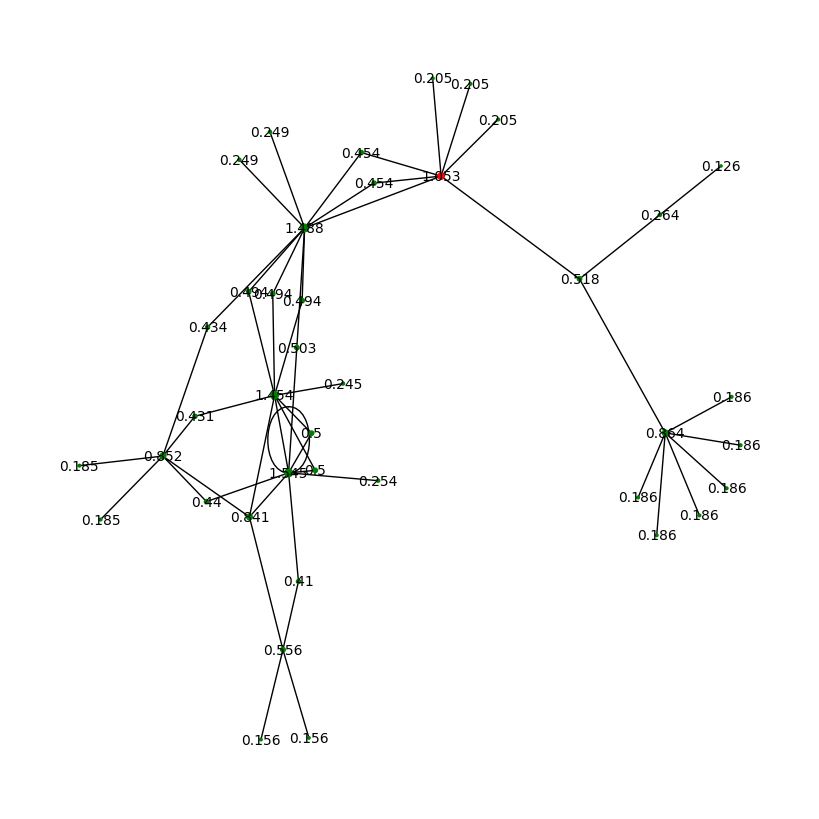

In [27]:
plt.figure(figsize=(8, 8))
nx.draw(school_graph[28]['graph'], 
        with_labels=True, 
        node_size=bonacich_centralities[28]*20, 
        labels=labels_dict, 
        node_color=color_mapping, 
        font_size=10)
plt.show()

In [28]:
np.sum(school_graph[28]['activity'])

0.5858226225336388

In [29]:
schools_raw_28_no_key_player = schools_raw_28[schools_raw_28['aid'] != key_players[0]]

In [30]:
ex_one_f2 = ex1(friends_raw, schools_raw_28_no_key_player)

data = ex_one_f2.clean()
school_graph = ex_one_f2.generate_graphs()
school_graph
filtered_schools = ex_one_f2.compute_largest_eigenvalues_and_filter(beta=0.1)
bonacich_centralities = ex_one_f2.compute_bonacich_centrality(beta=0.1)
school_graph = ex_one_f2.compute_activity(alpha=0.01, beta=0.1)
np.sum(school_graph[28]['activity'])

0.4057491815884997

With the removal of the key player the aggregate activity declines considerably because the node was the only connection between two large parts of the graph. However, it is by far not the player with the highest bonacich centrality as we can see in the plot (key player in red)

## Exercise 2

In [31]:
import igraph as ig
from linearmodels.iv import IV2SLS

### 2.a

In [32]:
schools_raw = schools_raw.dropna(subset=['s1', 's2', 's12', 's18','s6a', 's6b', 's6c', 's6d', 's6e'])
# friends = friends_raw.dropna(thresh=friends_raw.shape[1] - 8)

ex_one_temp = ex1(friends_raw, schools_raw)

data = ex_one_temp.clean()

ex_two = ex2(data=data)

In [33]:
ex_two.generate_one_graph(school_code=168)
median_school = ex_two.correct_activity()

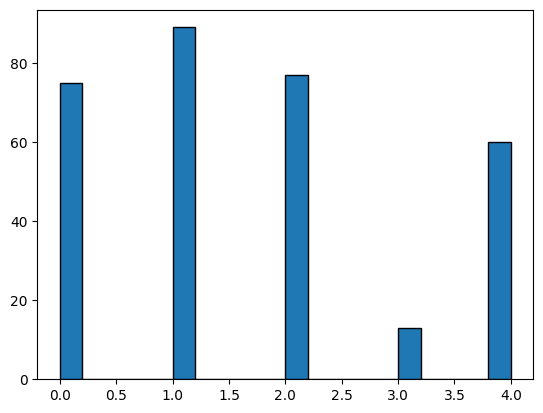

In [34]:
# Iterate over all vertices and print their activity attribute
activities = []
for node in median_school.vs:
    activities.append(node['activity'])

plt.hist(activities, bins=20, edgecolor='black')
plt.show()

### 2.b

In:

$$y = αι + βGy + γX + ε,  E(ε|x) = 0$$

if $ηβ + γ \neq 0$ and $I, G, G^2$  are linearly independent, θ is point-identified


In [35]:
adjacency_matrix = np.array(median_school.get_adjacency().data)
degrees = np.array(median_school.degree())

# Normalize each row of the adjacency matrix
row_sums = adjacency_matrix.sum(axis=1)
G = adjacency_matrix / row_sums[:, np.newaxis]

# Calculate I and G^2
I = np.identity(G.shape[0])
G2 = np.linalg.matrix_power(G, 2)

# Stack the matrices 
stacked_matrix = np.hstack((I, G, G2))

# Calculate the total number of rows in the stacked matrix
total_rows = stacked_matrix.shape[0]

# Check the rank of the stacked matrix
rank = np.linalg.matrix_rank(stacked_matrix)

# Print the total number of columns
print("Total number of rows in the stacked matrix:", total_rows)

# Print the rank
print("Rank of the stacked matrix:", rank)

# Check if the rank equals the total number of columns (linear independence check)
if rank == total_rows:
    print("The matrices are linearly independent.")
else:
    print("The matrices are linearly dependent.")

Total number of rows in the stacked matrix: 314
Rank of the stacked matrix: 314
The matrices are linearly independent.


### 2.c

(c) What is your vector of instruments? Is the model over-identified?


$G^2X$ could be used as an instrument for Gy, so we have to check the shape of the vector of instruments.

In [36]:
# Define y
y = np.array(median_school.vs['activity'])

# Perform Gy calculation 
Gy = np.dot(G, y)

# Define X
X = schools_raw[['s1', 's2', 's12', 's18', 's6a', 's6b', 's6c', 's6d', 's6e', 'aid']]
X = pd.merge(pd.DataFrame({'aid': median_school.vs['name']}), X, on='aid', how='left').drop(columns=['aid'])

# Instrument(s)
G2x = np.dot(G2, X)

# Check the shape of the resulting array
print("Number of instruments:", G2x.shape[1])

Number of instruments: 9


Since we have 9 instruments for $\beta$, our endogenous variable is over-identified

### 2.d

In [37]:
# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X.shape[0]), X))

# Fit the IV2SLS model with the constant term
model = IV2SLS(dependent=y, exog=X_with_const, endog=Gy, instruments=G2x).fit()

# Print model summary
print(model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                      0.0189
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0135
No. Observations:                 314   F-statistic:                    13.220
Date:                Thu, May 02 2024   P-value (F-stat)                0.2116
Time:                        23:13:01   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0         2.8645     1.1956     2.3959     0.0166      0.5212      5.2077
exog.1        -0.0255     0.0908    -0.2813     0.77

The endogenous peer effect in this case would be -0.1580, so clearly not what we would expect since that would imply that higher activity from peers discourages own activity, although it is still stat. insignificant so it is not possible to infer any peer effect.

### 2.e

In [38]:
graphs = ex_two.generate_all_graphs()

In [39]:
# Sample schools (for computational speed)
graphs_sample = graphs.sample(40, random_state=23).index
graph_list = graphs.loc[graphs_sample][None]

In [40]:
block_list_G = []
block_list_G2 = []

for graph in graph_list:
    G = np.array(graph.get_adjacency().data)
        
    # Ensure each G is row-stochastic
    row_sums = G.sum(axis=1)
    G_row_stochastic = G / row_sums[:, np.newaxis]
    
    block_list_G.append(G_row_stochastic)
    
    G2 = np.linalg.matrix_power(G_row_stochastic, 2)
    block_list_G2.append(G2)

block_G = sp.block_diag(block_list_G, format='csr')
block_G2 = sp.block_diag(block_list_G2, format='csr')

In [41]:
# Function to calculate all activities
def list_activity(graphs):
    activity_list = []
    for graph in graphs:
        activity_list.extend(graph.vs['activity'])
    return np.nan_to_num(np.array(activity_list), nan=0)

y_all = list_activity(graph_list)

In [42]:
# Calculate Gy
Gy = np.dot(block_G.toarray(), y_all)

In [43]:
# Define X
features = schools_raw[['s1', 's2', 's12', 's18', 's6a', 's6b', 's6c', 's6d', 's6e', 'aid']]
X = pd.concat([pd.merge(pd.DataFrame({'aid': graph.vs['name']}), features, on='aid', how='left').drop(columns=['aid']) for graph in graph_list], axis=0)

In [44]:
# Calculate G2x
G2x = np.dot(block_G2.toarray(), X)

In [45]:
# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X.shape[0]), X))

# Fit the IV2SLS model with the constant term
model = IV2SLS(dependent=y_all, exog=X_with_const, endog=Gy, instruments=G2x).fit()

# Print model summary
print(model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                     -0.0011
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0016
No. Observations:               21132   F-statistic:                    327.39
Date:                Thu, May 02 2024   P-value (F-stat)                0.0000
Time:                        23:13:21   Distribution:                 chi2(10)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0         0.5543     0.3028     1.8304     0.0672     -0.0392      1.1478
exog.1        -0.0160     0.0110    -1.4442     0.14

With more schools the effect becomes positive, statistically significant and also quite large, more than the 0.1 we asssumed in exercise 1.

### 2.f

In [46]:
def get_X_stacked_fe(graph_list):
    features = schools_raw[['s1', 's2', 's12', 's18', 's6a', 's6b', 's6c', 's6d', 's6e', 'aid']]
    X_fe = pd.concat([pd.merge(pd.DataFrame({'aid': graph.vs['name']}), features, on='aid', how='left').drop(columns=['aid']).assign(alpha=idx) for idx, graph in enumerate(graph_list)], axis=0)
    return X_fe

In [47]:
X_fe = get_X_stacked_fe(graph_list)

# Add a column of ones to X for the constant term
X_with_const = np.column_stack((np.ones(X_fe.shape[0]), X_fe))

# Fit the IV2SLS model with the constant term
model = IV2SLS(dependent=y_all, exog=X_with_const, endog=Gy, instruments=G2x).fit()

# Print model summary
print(model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              dependent   R-squared:                     -0.0008
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0014
No. Observations:               21132   F-statistic:                    334.26
Date:                Thu, May 02 2024   P-value (F-stat)                0.0000
Time:                        23:13:22   Distribution:                 chi2(11)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
exog.0         0.5689     0.3124     1.8208     0.0686     -0.0435      1.1812
exog.1        -0.0161     0.0110    -1.4528     0.14

Controlling for the school fixed effects, the peer effect is slightly lower, which would mean that the schools that were randomly sampled are quite similar (?)